## Ptype - ML!

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

We will do imports as they come in the notebook. I am happy to move them all to the top as well.

#### Read in the data

This could have been a .csv as well 

In [2]:
df = pd.read_parquet('0_data/ptype_sampled.parquet')
df.shape

(2000, 6)

In [3]:
memory_in_megabytes = df.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"The DataFrame size is: {memory_in_megabytes:.2f} MB")

The DataFrame size is: 0.15 MB


So we have 2000 rows, and 6 columns

In [4]:
column_names = df.columns.tolist()
print(column_names)

['TEMP_C_0_m', 'T_DEWPOINT_C_0_m', 'PRES_Pa_0_m', 'UGRD_m/s_0_m', 'VGRD_m/s_0_m', 'ptype']


Let's pull out the variables that are at the surface and maybe a few more:

## Let's do EDA

EDA = Exploratory Data Analysis

In [5]:
df.describe()

,TEMP_C_0_m,T_DEWPOINT_C_0_m,PRES_Pa_0_m,UGRD_m/s_0_m,VGRD_m/s_0_m
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,7.191655,4.295661,97771.921875,0.245982,-0.635261
std,11.015686,10.693260,4340.965332,3.244669,3.497568
min,-19.339417,-23.740677,68586.640625,-12.982805,-12.780014
25%,-0.677414,-3.349205,97349.937500,-1.848213,-2.909421
50%,2.912354,0.713211,98749.937500,-0.040516,-0.531640
75%,17.254036,14.244499,100049.683594,2.224049,1.671326
max,33.993225,26.039459,103628.171875,11.791678,11.930449


Each column has all of the data! Each variable has different means, but some have different standard deviations. 

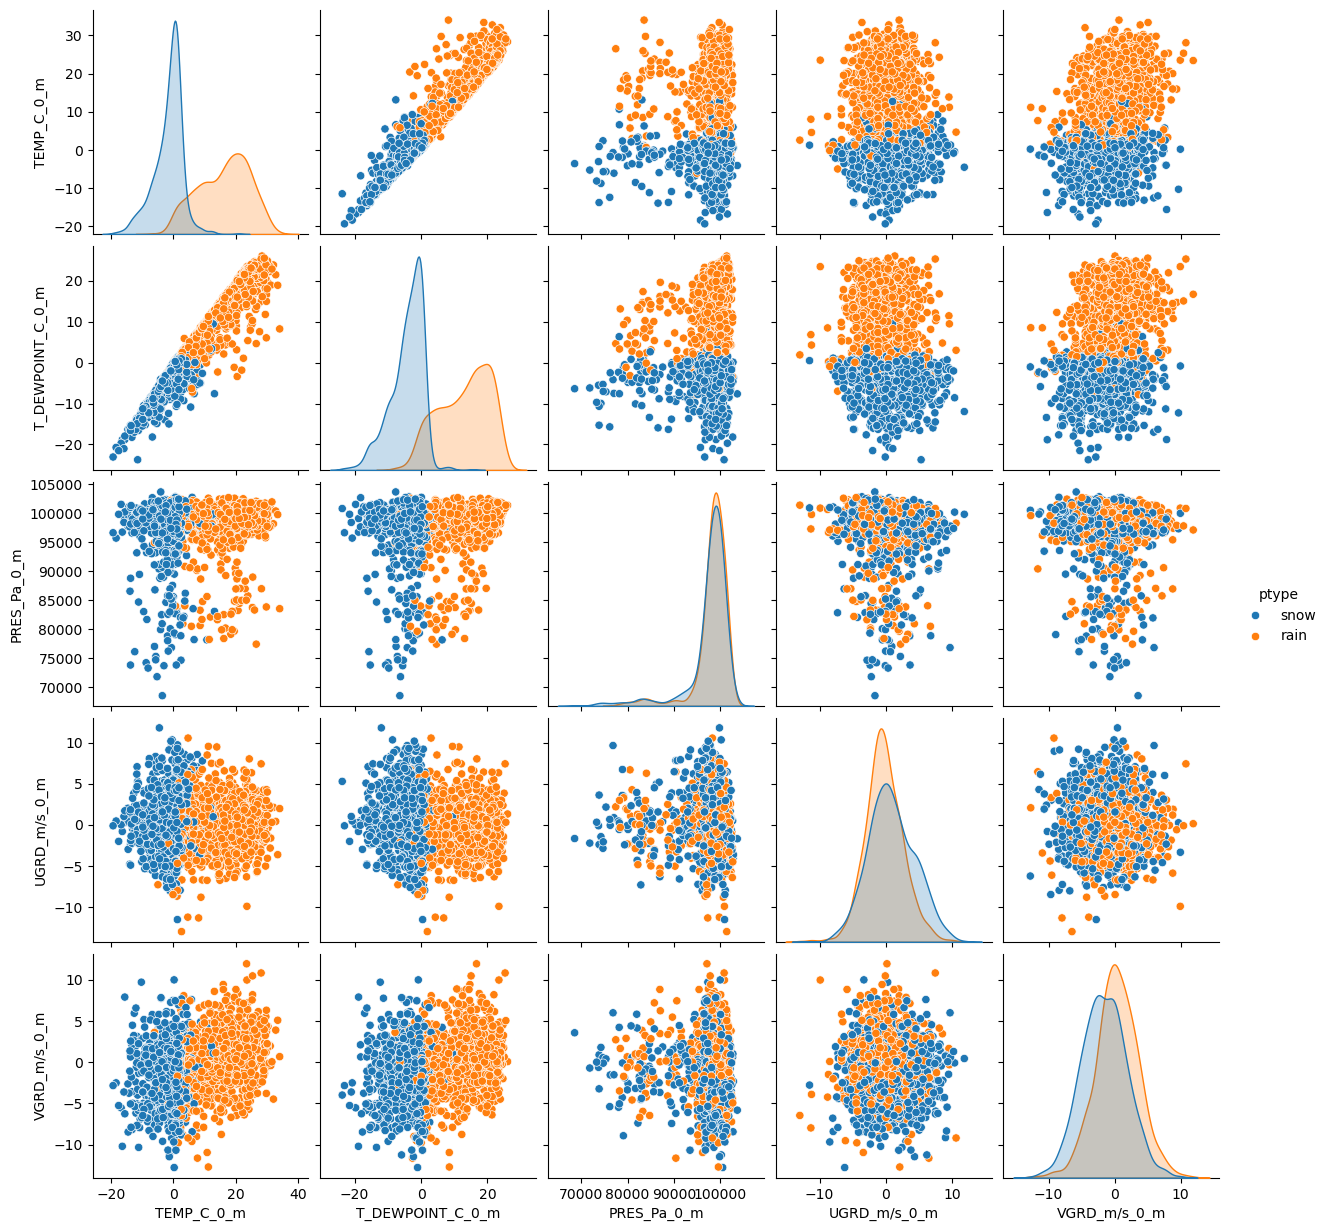

In [6]:
sns.pairplot(df, hue='ptype')

Notice any trends so far? What input features might be the most important? 

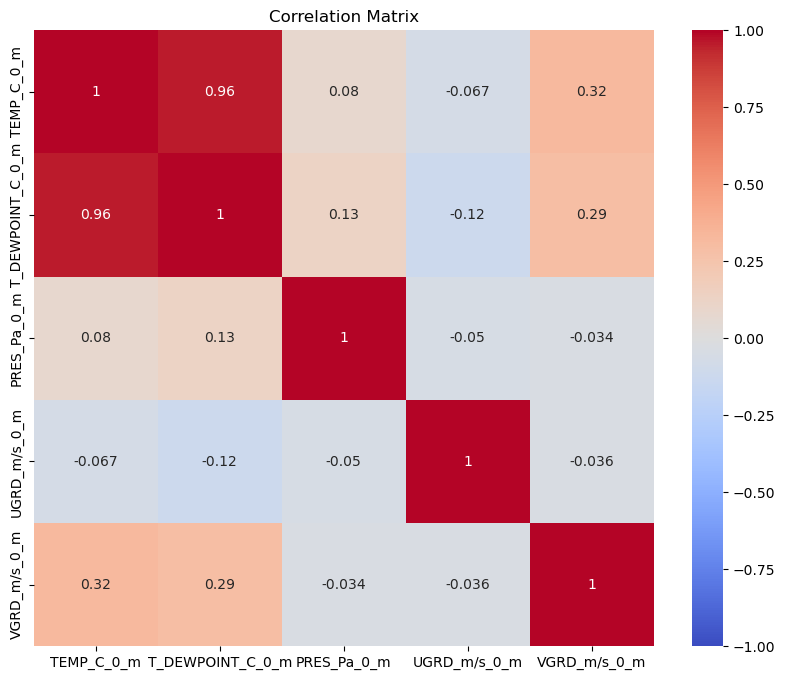

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes(include=['number']).corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

We are going to drop some columns with repeptitive data:

Let's re-plot the correlation matrix

## Splitting Datasets

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = df[['TEMP_C_0_m', 'T_DEWPOINT_C_0_m', 'PRES_Pa_0_m','UGRD_m/s_0_m', 'VGRD_m/s_0_m' ]]
y = df['ptype']

Our two target variables:

In [10]:
y.unique()

array(['snow', 'rain'], dtype=object)

In [12]:
# Splitting into training and temporary set (70% training, 30% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Splitting the temporary set into testing and validation sets (20% testing, 10% validation of the original dataset)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

## Scaling Your Data

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
# Initialize the scaler
scaler = StandardScaler()

In [15]:
# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing and validation data using the same scaler
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

One note, always scale the datasets after splitting

## Machine Learning

#### Training

This is a simple problem, can choose logistic regression or support vector machine as our classification model

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [21]:
# Initialize the Logistic Regression model
# model = LogisticRegression()

# Support Vector (Machines) Classifier
model = LogisticRegression()

In [22]:
# Train the model with the training data
model.fit(X_train_scaled, y_train)

LogisticRegression()

Let's use the testing data

In [23]:
# Predicting the Test set results
y_pred = model.predict(X_test_scaled)

#### Accuracy

In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [25]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy*100:.2f}%")

Accuracy on Test Set: 95.25%


In [26]:
# More detailed performance analysis
print("Classification Report for Test Set:")
print(classification_report(y_test, y_pred))

Classification Report for Test Set:
              precision    recall  f1-score   support

        rain       1.00      0.90      0.95       198
        snow       0.91      1.00      0.96       202

    accuracy                           0.95       400
   macro avg       0.96      0.95      0.95       400
weighted avg       0.96      0.95      0.95       400



In [27]:
cm = confusion_matrix(y_test, y_pred)

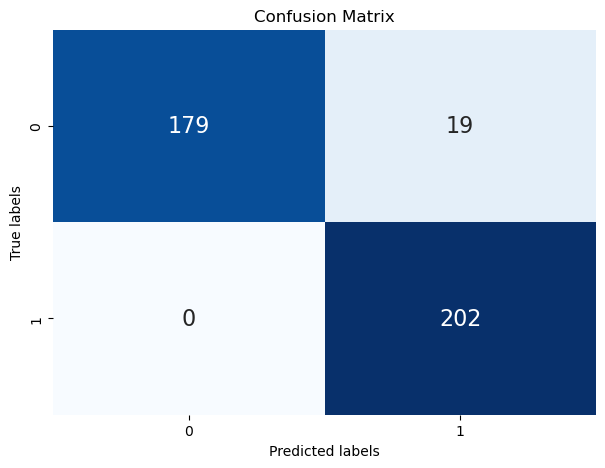

In [28]:
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',annot_kws={"size": 16}, cbar=False)

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show plot
plt.show()

A perfect confusion matrix would only have the diagonal colored in. 

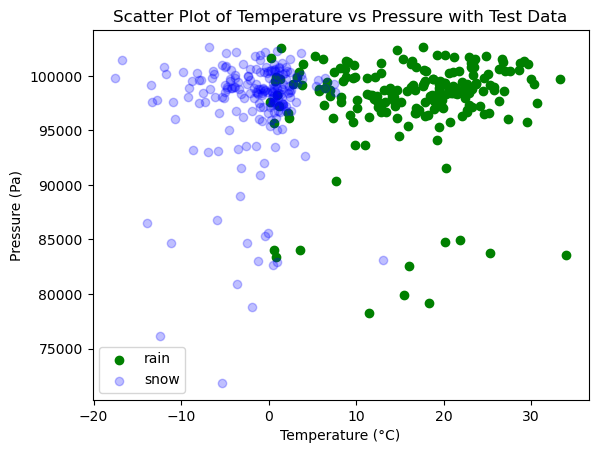

In [29]:
category_dict = {'rain': 0, 'snow': 1}
numeric_categories = np.array([category_dict[cat] for cat in y_test])

# Plot rain data points
plt.scatter(X_test['TEMP_C_0_m'][numeric_categories == 0], 
            X_test['PRES_Pa_0_m'][numeric_categories == 0], 
            c='green', label='rain')

# Plot snow data points
plt.scatter(X_test['TEMP_C_0_m'][numeric_categories == 1], 
            X_test['PRES_Pa_0_m'][numeric_categories == 1], 
            c='blue',
            alpha=0.25,
            label='snow')

# Add legend
plt.legend()

plt.xlabel('Temperature (°C)')  # Label for x-axis
plt.ylabel('Pressure (Pa)')      # Label for y-axis

plt.title('Scatter Plot of Temperature vs Pressure with Test Data')

plt.show()

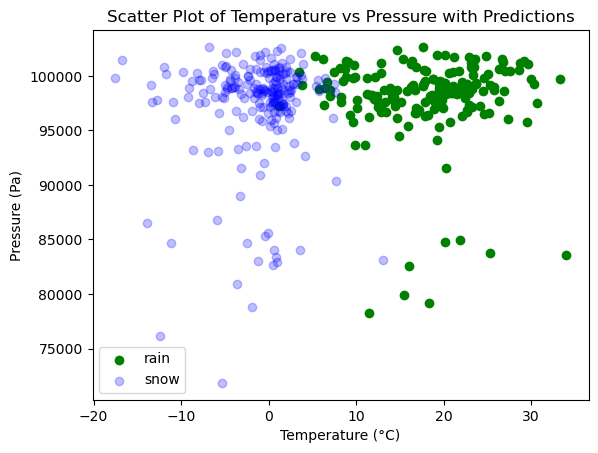

In [30]:
category_dict = {'rain': 0, 'snow': 1}
numeric_categories = np.array([category_dict[cat] for cat in y_pred])

# Plot rain data points
plt.scatter(X_test['TEMP_C_0_m'][numeric_categories == 0], 
            X_test['PRES_Pa_0_m'][numeric_categories == 0], 
            c='green', label='rain')

# Plot snow data points
plt.scatter(X_test['TEMP_C_0_m'][numeric_categories == 1], 
            X_test['PRES_Pa_0_m'][numeric_categories == 1], 
            c='blue',
            alpha=0.25,
            label='snow')

# Add legend
plt.legend()

plt.xlabel('Temperature (°C)')  # Label for x-axis
plt.ylabel('Pressure (Pa)')      # Label for y-axis

plt.title('Scatter Plot of Temperature vs Pressure with Predictions')

plt.show()

What are the differences between the two plots? One thing to keep in mind is the MPing reports of the data are messy (made by people / general public).

With this in mind, do we expect 

#### Now let's try it on the validation set

In [31]:
# Predicting the Validation set results
y_val_pred = model.predict(X_val_scaled)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy on Validation Set: {val_accuracy*100:.2f}%")

# More detailed performance analysis
print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred))

Accuracy on Validation Set: 94.00%
Classification Report for Validation Set:
              precision    recall  f1-score   support

        rain       0.96      0.92      0.94        95
        snow       0.93      0.96      0.94       105

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



In [32]:
cm_val = confusion_matrix(y_val, y_val_pred)

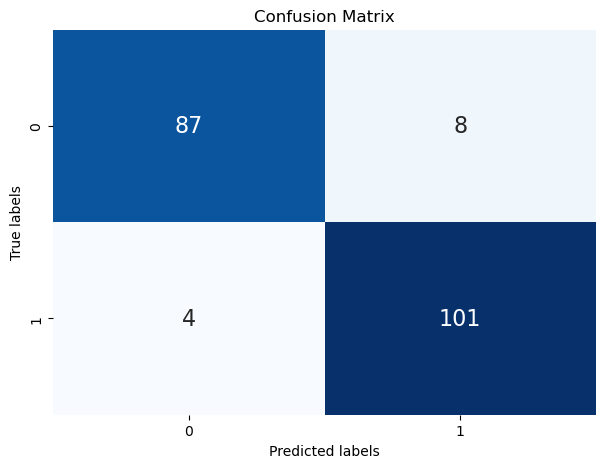

In [33]:
plt.figure(figsize=(7, 5))
sns.heatmap(cm_val, annot=True, cmap='Blues', fmt='g',annot_kws={"size": 16}, cbar=False)

# Add labels and title
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# Show plot
plt.show()

For these two datasets (testing and validation) we want to compare the overall metrics. Are they similar? does one perform worse? How do you think the model will work on new, unseen data based off of these results?

## Snow vs Freezing Rain

In [34]:
df_frza = pd.read_parquet('0_data/ptype_sampled_frza.parquet')

In [35]:
df_frza.describe()

,TEMP_C_0_m,T_DEWPOINT_C_0_m,PRES_Pa_0_m,UGRD_m/s_0_m,VGRD_m/s_0_m
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,-1.224230,-3.480852,97853.976562,-0.276727,-1.568403
std,4.247178,4.457617,4084.322754,3.331566,3.333238
min,-19.303024,-24.025223,67854.320312,-11.178705,-14.452679
25%,-3.115570,-5.516388,97356.414062,-2.465180,-3.786891
50%,-0.692780,-2.609085,98588.738281,-0.602569,-1.692378
75%,0.643044,-0.705284,99923.923828,1.779485,0.665858
max,27.657043,25.156921,103556.835938,16.121258,10.243851


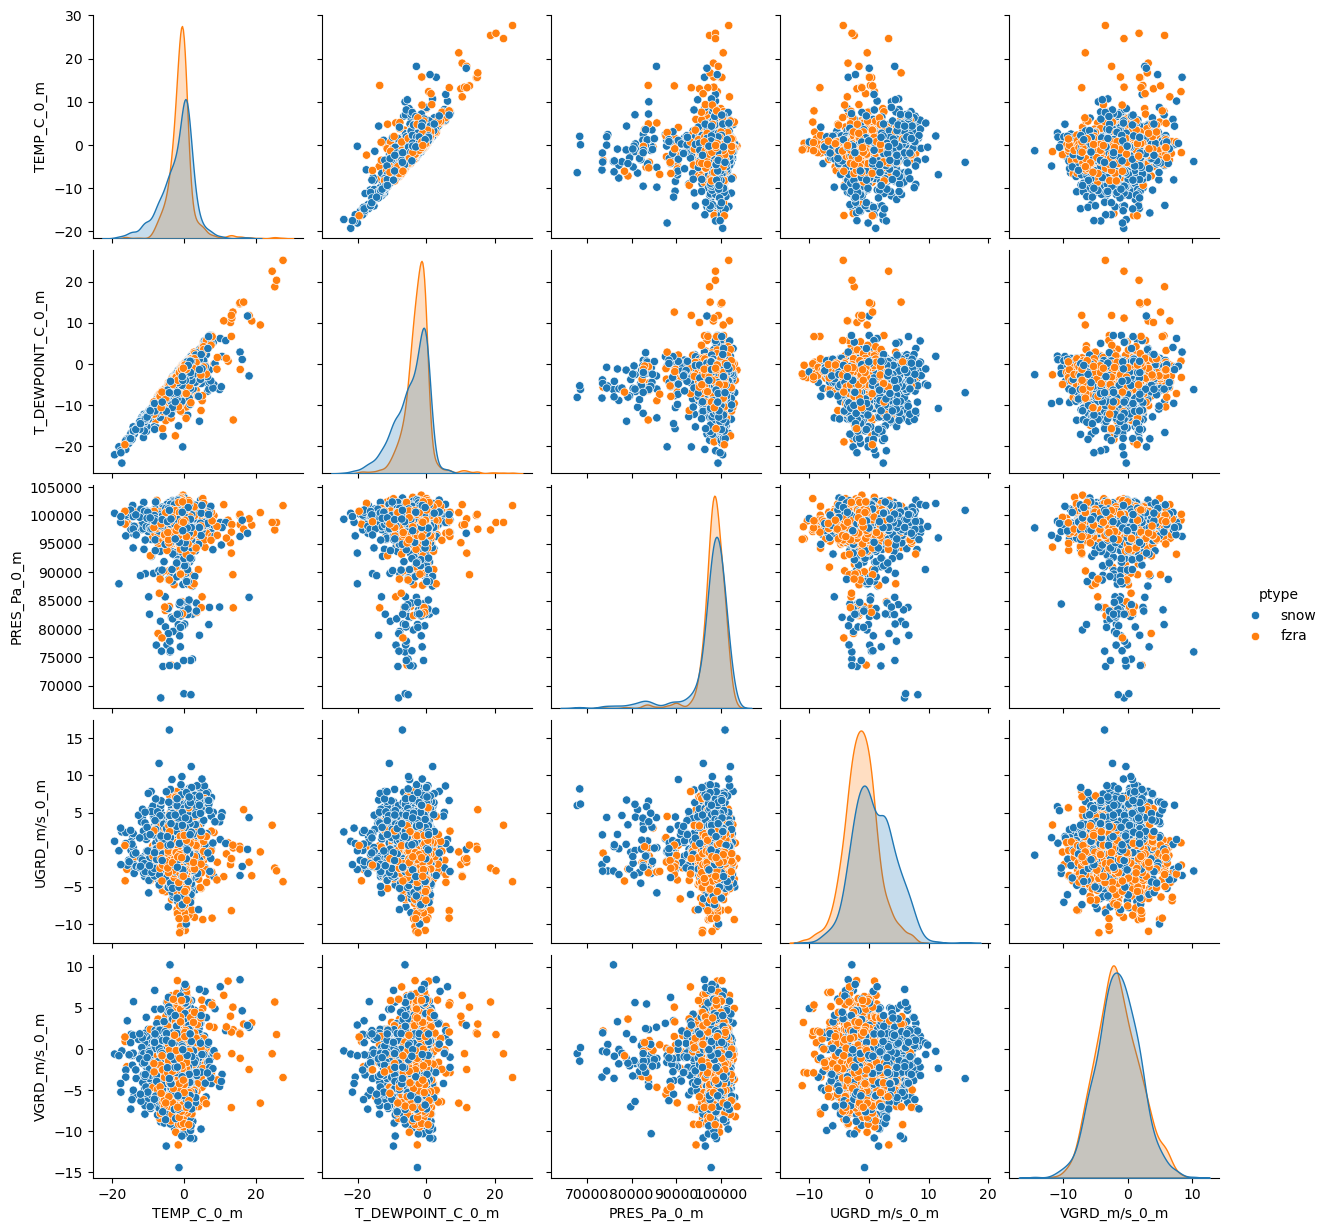

In [36]:
sns.pairplot(df_frza, hue='ptype')

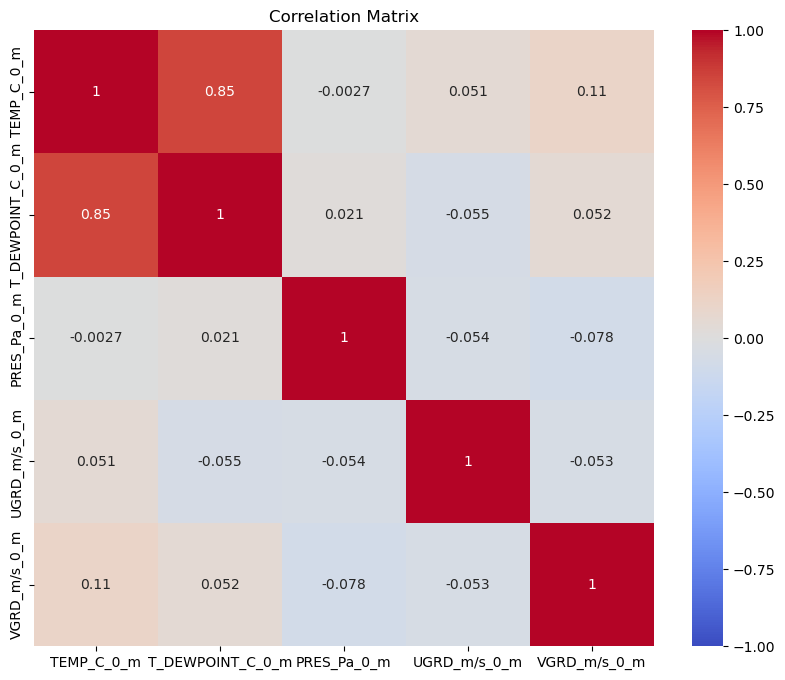

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_frza.select_dtypes(include=['number']).corr(), vmin=-1, vmax=1, cmap='coolwarm', annot=True)
plt.title('Correlation Matrix')
plt.show()

What are the differences in EDA compared to rain vs snow? Do you expect this to do better or worse compared to rain vs snow?

#### Split up the data & Scale

This is a bit compressed, but is the same line for line as above, just with a new dataset

In [38]:
X = df_frza[['TEMP_C_0_m', 'T_DEWPOINT_C_0_m', 'PRES_Pa_0_m','UGRD_m/s_0_m', 'VGRD_m/s_0_m' ]]
y = df_frza['ptype']

In [39]:
# Splitting into training and temporary set (70% training, 30% temporary)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Splitting the temporary set into testing and validation sets (20% testing, 10% validation of the original dataset)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

In [40]:
# Initialize the scaler
scaler = StandardScaler()

In [41]:
# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing and validation data using the same scaler
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

In [42]:
# Support Vector (Machines) Classifier
model = SVC()

In [43]:
# Train the model with the training data
model.fit(X_train_scaled, y_train)

SVC()

## Test Set ML

In [44]:
# Predicting the Test set results
y_pred = model.predict(X_test_scaled)

In [45]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on Test Set: {accuracy*100:.2f}%")

Accuracy on Test Set: 69.50%


In [46]:
# More detailed performance analysis
print("Classification Report for Test Set:")
print(classification_report(y_test, y_pred))

Classification Report for Test Set:
              precision    recall  f1-score   support

        fzra       0.66      0.78      0.72       198
        snow       0.74      0.61      0.67       202

    accuracy                           0.69       400
   macro avg       0.70      0.70      0.69       400
weighted avg       0.70      0.69      0.69       400



## Validation Set ML 

In [47]:
# Predicting the Validation set results
y_val_pred = model.predict(X_val_scaled)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy on Validation Set: {val_accuracy*100:.2f}%")

# More detailed performance analysis
print("Classification Report for Validation Set:")
print(classification_report(y_val, y_val_pred))

Accuracy on Validation Set: 67.50%
Classification Report for Validation Set:
              precision    recall  f1-score   support

        fzra       0.63      0.76      0.69        95
        snow       0.73      0.60      0.66       105

    accuracy                           0.68       200
   macro avg       0.68      0.68      0.67       200
weighted avg       0.68      0.68      0.67       200



### More Questions


What do you see comparing the metrics; freezing rain vs snow and snow vs rain?

Is the SVM model consistent between testing and validations sets for both experiments? Could we potentially use a more complex model? 

How many lines of code does it take to do a quick ML analysis with a testing, training, and validation dataset?